## Import packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xesmf as xe
import numpy as np
import geopandas as gpd
import shapely.geometry as geom
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import cartopy.crs as ccrs
from scipy.stats import mannwhitneyu

## Load data 

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'stratiform_rainfall_flux'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable]

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable]

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')[variable]

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')[variable]

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')[variable]

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')[variable]

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')[variable]

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')[variable]


In [3]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

## Land only, sum to daily totals

In [4]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

In [5]:
#sum to total rainfall over time series
allvar_total = (allvar * 3600).sum(dim="time", skipna=True)
control_total = (control * 3600).sum(dim="time", skipna=True)
albedo_bare_total = (albedo_bare * 3600).sum(dim="time", skipna=True)
albedo_total = (albedo * 3600).sum(dim="time", skipna=True)
bare_total = (bare * 3600).sum(dim="time", skipna=True)
SM_albedo_total = (SM_albedo * 3600).sum(dim="time", skipna=True)
SM_bare_total = (SM_bare  * 3600).sum(dim="time", skipna=True)
SM_total = (SM * 3600).sum(dim="time", skipna=True)

In [7]:
experiments = {
    "All Variables": allvar,
    "Control": control,
    "Albedo + Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + Albedo": SM_albedo,
    "SM + Bare": SM_bare,
    "SM": SM
}

for name in experiments:
    experiments[name] = experiments[name].assign_coords(time=experiments[name].time + pd.Timedelta(hours=10))
    experiments[name] = experiments[name] * 3600 #from kg/m2/s to mm/h
    experiments[name] = experiments[name].where(landmask == 1)

# SPATIAL

## Difference plots, entire period

In [8]:
def significance_mask_mwu(exp, control, landmask, alpha=0.05):
    """
    Compute Mann–Whitney U significance mask for each grid point
    using the original time series (not the cumulative total).
    
    Parameters
    ----------
    exp : xarray.DataArray
        Experiment time series (time x lat x lon)
    control : xarray.DataArray
        Control time series (time x lat x lon)
    landmask : xarray.DataArray
        Land mask (1=land, 0=non-land)
    alpha : float
        Significance threshold
    
    Returns
    -------
    sig_mask : xarray.DataArray (bool)
        True where Mann–Whitney U test is significant
    """
    #mask
    sig_mask = xr.full_like(exp.isel(time=0), False, dtype=bool)
    
    for lat_idx in range(exp.latitude.size):
        for lon_idx in range(exp.longitude.size):
            exp_vals = exp[:, lat_idx, lon_idx].values
            ctrl_vals = control[:, lat_idx, lon_idx].values
            
            #remove NaN
            exp_vals = exp_vals[~np.isnan(exp_vals)]
            ctrl_vals = ctrl_vals[~np.isnan(ctrl_vals)]
            
            if len(exp_vals) > 1 and len(ctrl_vals) > 1:
                _, p = mannwhitneyu(exp_vals, ctrl_vals, alternative='two-sided')
                sig_mask[lat_idx, lon_idx] = (p < alpha)
    
   #landmask
    sig_mask = sig_mask & (landmask == 1)
    return sig_mask

In [13]:
#perform Mann-Whitney
sigmask_dict = {}

for name, exp in experiments.items():
    if name == "Control":
        continue  # skip reference
    sigmask_dict[name] = significance_mask_mwu(exp, control, landmask)

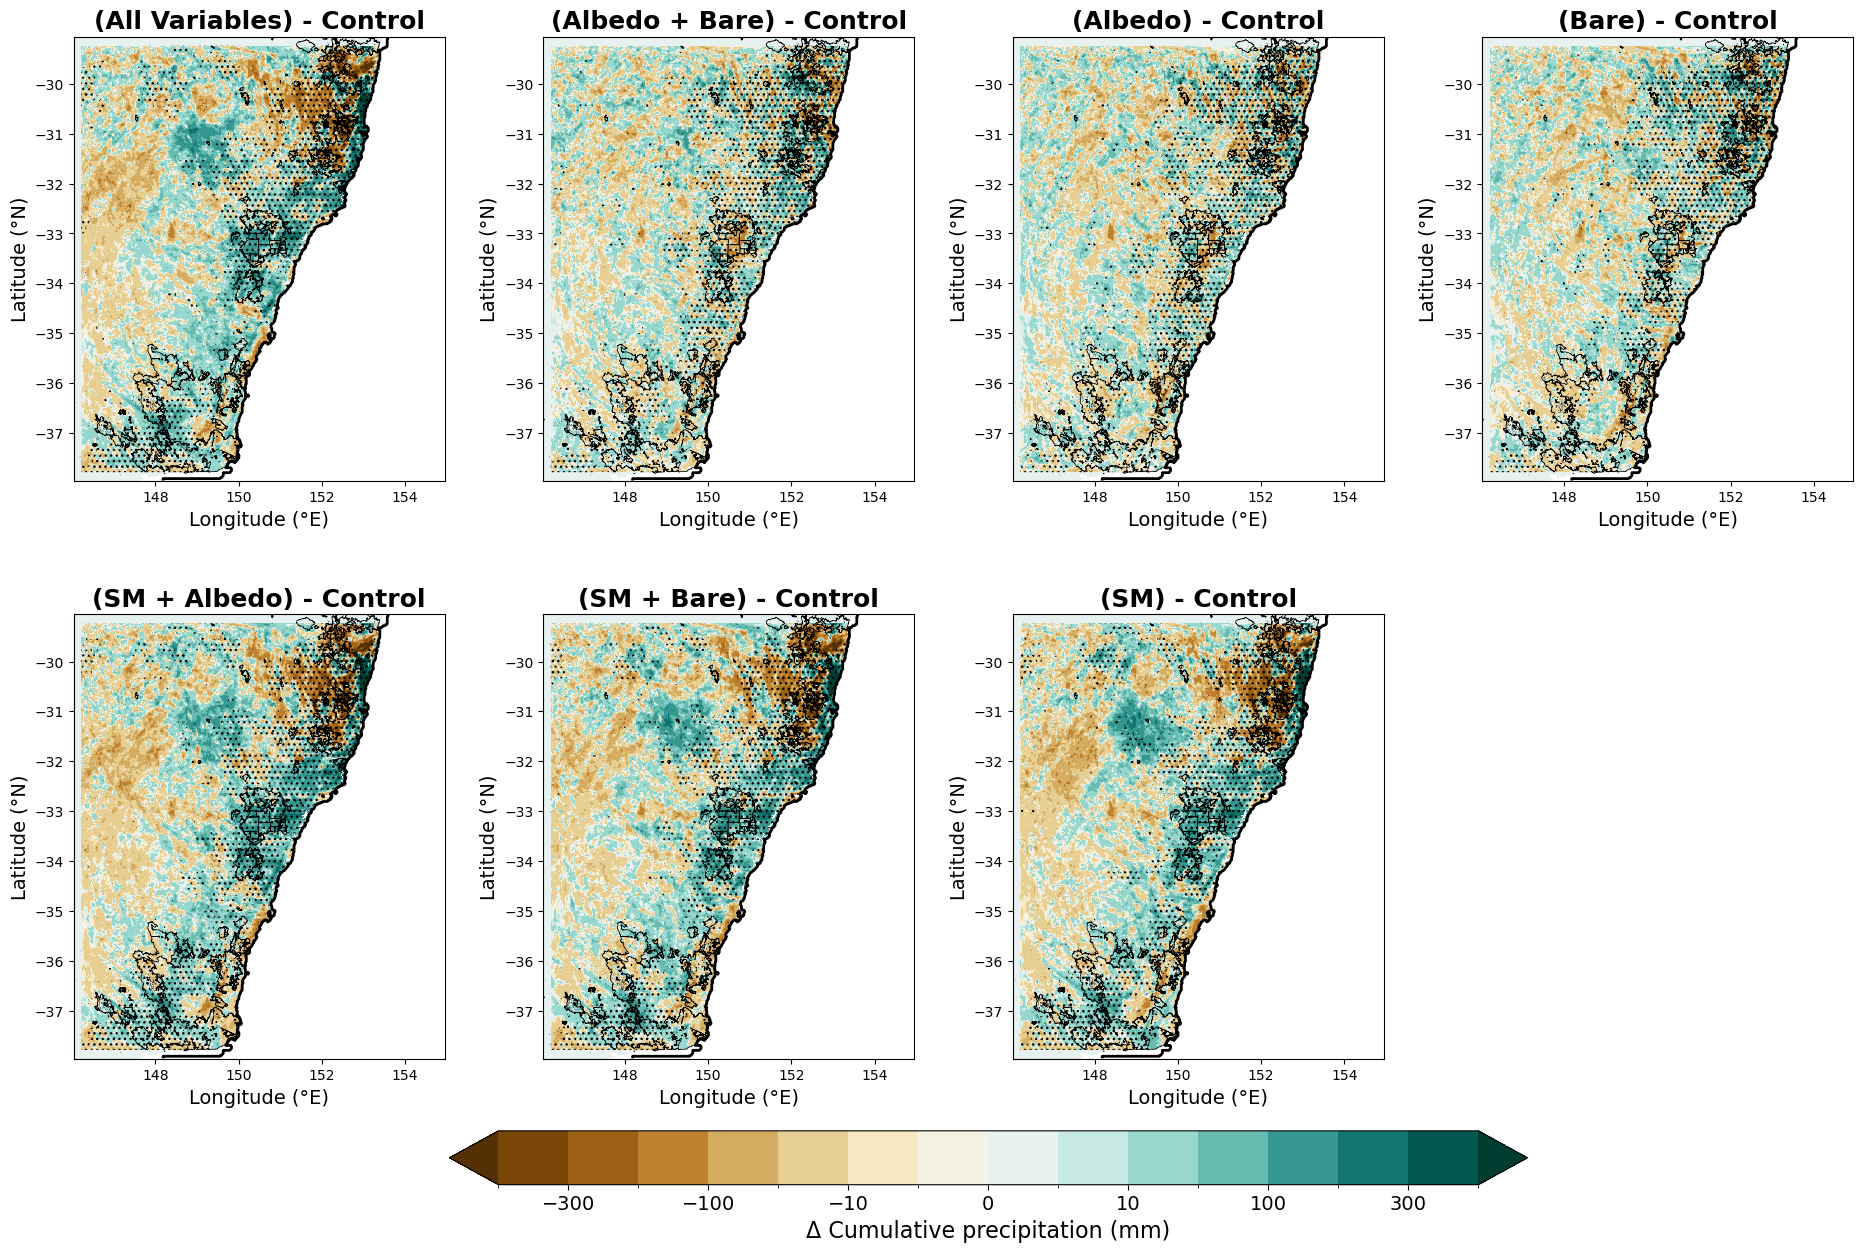

In [30]:
totals = {
    "All Variables": allvar_total,
    "Control": control_total,
    "Albedo + Bare": albedo_bare_total,
    "Albedo": albedo_total,
    "Bare": bare_total,
    "SM + Albedo": SM_albedo_total,
    "SM + Bare": SM_bare_total,
    "SM": SM_total,
}
for key in totals:
    totals[key] = totals[key].where(landmask == 1)

names = list(totals.keys())
ref_index = 1 #index of ref, 0 = allvar
ref_name = names[ref_index]

ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
axes = axes.flatten()

plot_idx = 0
cbar_ax = None 

for i, name in enumerate(names):
    if i == ref_index:
        continue  #skip reference 

    diff = totals[name] - totals[ref_name] 
    ax = axes[plot_idx]

    mesh = diff.plot(
        ax=ax,
        cmap="BrBG",
        center=0,
        levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
        extend="both",
        add_colorbar=False
    )

    if plot_idx == 0:
        cbar_ax = mesh 
    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

#stipple
    if name in sigmask_dict:
        sigmask_dict[name].plot.contourf(
            ax=ax,
            levels=[0.5,1],  #where mask = 1     
            hatches=["","..."], 
            colors="none",
            add_colorbar=False
        )

    ax.set_title(f"({name}) - {ref_name}", fontsize = 18, fontweight = 'bold')
    ax.set_xlabel("Longitude (°E)", fontsize=14)
    ax.set_ylabel("Latitude (°N)", fontsize=14)

    plot_idx += 1

#remove unused axis
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

#shared colorbar along the bottom
cbar = fig.colorbar(
    cbar_ax, ax=axes[:plot_idx],
    orientation='horizontal',
    fraction=0.05,
    pad=0.02      
)

cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Δ Cumulative precipitation (mm)", fontsize=16)

#adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)

# fig.suptitle(f"Difference of {ref_name} vs all other runs (full period)", fontsize=16)
# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/cumulative_difference_stipple.png', dpi = 300, bbox_inches='tight')
plt.show()


## 90% range of values

In [15]:
#differences for SM experiment
sm_diff = totals["SM"] - totals[ref_name]

#drop nan
sm_diff_valid = sm_diff.where(~np.isnan(sm_diff), drop=True)

#5th and 95th percentiles
p5_diff = np.nanpercentile(sm_diff_valid, 5)
p95_diff = np.nanpercentile(sm_diff_valid, 95)

print(f"SM vs {ref_name}:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")


SM vs Control:
  5th percentile difference: -97.99 mm (below control)
 95th percentile difference: 114.86 mm (above control)


In [19]:
#differences for Allvar experiment
sm_diff = totals["All Variables"] - totals[ref_name]

#drop nan
sm_diff_valid = sm_diff.where(~np.isnan(sm_diff), drop=True)

#5th and 95th percentiles
p5_diff = np.nanpercentile(sm_diff_valid, 5)
p95_diff = np.nanpercentile(sm_diff_valid, 95)

print(f"Allvar vs {ref_name}:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")


Allvar vs Control:
  5th percentile difference: -96.38 mm (below control)
 95th percentile difference: 116.66 mm (above control)


In [20]:
#differences for SM + bare experiment
sm_diff = totals["SM + Bare"] - totals[ref_name]

#drop nan
sm_diff_valid = sm_diff.where(~np.isnan(sm_diff), drop=True)

#5th and 95th percentiles
p5_diff = np.nanpercentile(sm_diff_valid, 5)
p95_diff = np.nanpercentile(sm_diff_valid, 95)

print(f"SM +Bare vs {ref_name}:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")


SM +Bare vs Control:
  5th percentile difference: -97.53 mm (below control)
 95th percentile difference: 112.72 mm (above control)


In [21]:
#differences for SM + albedo experiment
sm_diff = totals["SM + Albedo"] - totals[ref_name]

#drop nan
sm_diff_valid = sm_diff.where(~np.isnan(sm_diff), drop=True)

#5th and 95th percentiles
p5_diff = np.nanpercentile(sm_diff_valid, 5)
p95_diff = np.nanpercentile(sm_diff_valid, 95)

print(f"SM + Albedo vs {ref_name}:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")


SM + Albedo vs Control:
  5th percentile difference: -95.88 mm (below control)
 95th percentile difference: 117.46 mm (above control)


In [22]:
#differences for Albedo experiment
sm_diff = totals["Albedo"] - totals[ref_name]

#drop nan
sm_diff_valid = sm_diff.where(~np.isnan(sm_diff), drop=True)

#5th and 95th percentiles
p5_diff = np.nanpercentile(sm_diff_valid, 5)
p95_diff = np.nanpercentile(sm_diff_valid, 95)

print(f"Albedo vs {ref_name}:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")


Albedo vs Control:
  5th percentile difference: -66.78 mm (below control)
 95th percentile difference: 65.26 mm (above control)


In [23]:
#differences for Albedo + bare experiment
sm_diff = totals["Albedo + Bare"] - totals[ref_name]

#drop nan
sm_diff_valid = sm_diff.where(~np.isnan(sm_diff), drop=True)

#5th and 95th percentiles
p5_diff = np.nanpercentile(sm_diff_valid, 5)
p95_diff = np.nanpercentile(sm_diff_valid, 95)

print(f"Albedo + Bare vs {ref_name}:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")


Albedo + Bare vs Control:
  5th percentile difference: -66.66 mm (below control)
 95th percentile difference: 74.39 mm (above control)


In [24]:
#differences for Bare experiment
sm_diff = totals["Bare"] - totals[ref_name]

#drop nan
sm_diff_valid = sm_diff.where(~np.isnan(sm_diff), drop=True)

#5th and 95th percentiles
p5_diff = np.nanpercentile(sm_diff_valid, 5)
p95_diff = np.nanpercentile(sm_diff_valid, 95)

print(f"Bare vs {ref_name}:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")


Bare vs Control:
  5th percentile difference: -67.29 mm (below control)
 95th percentile difference: 70.18 mm (above control)
